# Tranformer

In [121]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

## 1. Механизм внимания (Scaled Dot-Product Attention)

Ключевая часть архитектуры трансформера — это механизм внимания. Он позволяет каждому токену входной последовательности взаимодействовать с другими токенами и учитывать их важность.

Каждый элемент последовательности сначала преобразуется в три вектора:

- Query (запрос) — что ищем.
- Key (ключ) — с чем сравниваем.
- Value (значение) — что извлекаем.

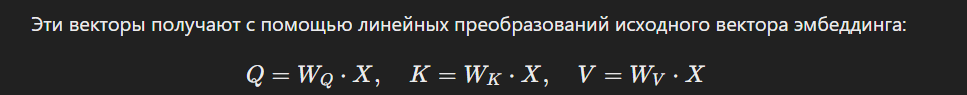

Механизм внимания вычисляется следующим образом:

1. Вычисление "совпадений" (similarity) между запросами и ключами. Это делается через скалярное произведение Q * K^T.

2. Применение softmax к этим значениям для получения весов внимания.
3. Эти веса используются для взвешивания соответствующих значений:
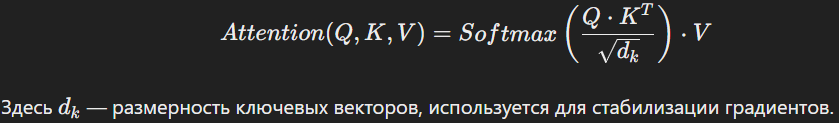


In [122]:
class ScaledDotProductAttention(nn.Module):
    """Attention"""

    def __init__(self, d_k):
        """Args:
        d_k (_type_): Размерность ключа
        """
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, mask=None):
        # Скалярное произведение Q и K
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Применяем маску, если она есть
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = F.softmax(scores, dim=-1)

        # Скалярное произведение attention и V
        output = torch.matmul(attention, V)
        return output, attention

## Multihead attention

Механизм, который позволяет модели сосредоточиться на разных частях входной последовательности одновременно.

- Модель обучается сосредотачиваться на разных позициях входной последовательности.
- Каждая "голова" в механизме внимания обрабатывает входные данные независимо, затем результаты объединяются.

Вместо одного механизма внимания используется несколько (от 8 до 12) независимых "голов", каждая из которых обучается сосредотачиваться на разных аспектах последовательности. Результаты всех голов объединяются и передаются в полносвязную сеть:
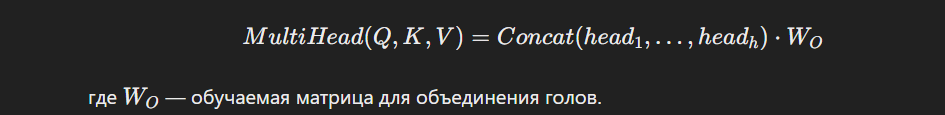


In [123]:
import torch.nn as nn


class MultiHeadAttention(nn.Module):
    """Multi-head attention"""

    def __init__(self, d_model: int, num_heads: int):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        #  Make sure d_model is divisible by h
        assert d_model % num_heads == 0, "d_model is not divisible by num_heads"

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]

        # Линейные преобразования для Q, K, V.
        Q = self.query(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.query(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.query(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Применим механизм внимания
        attn_output, _ = ScaledDotProductAttention(self.d_k)(Q, K, V, mask)

        # Объединяем головы
        attn_output = (
            attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        )
        output = self.fc_out(attn_output)
        return output

## Positional encoding

Поскольку трансформеры не имеют встроенной информации о порядке токенов (в отличие от рекуррентных сетей), используется позиционное кодирование (positional encoding). Оно добавляется к эмбеддингам токенов, чтобы модель могла учитывать порядок слов в последовательности. Позиционные коды создаются с помощью синусоидальных и косинусоидальных функций различной частоты.

In [124]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float = 0.1):
        super(PositionalEncoding, self).__init__()

        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix of max_len x d_model
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to even indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0)
        # Register the positional encoding as a buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Добавляем позиционные коды к эмбеддингам токенов
        x = x + self.pe[:, : x.shape[1], :].detach()

        return self.dropout(x)

# Feed forward

Это полносвязная сеть, которая применяет линейную трансформацию и нелинейную активацию (обычно ReLU) для обработки данных, прошедших через механизм self-attention.

In [125]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        x = self.dropout(torch.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

# Add & Norm Layer

Normalize the outputs and apply residual connections.

Остаточная связь применяется к выходам после каждого слоя внимания и полносвязной сети.
Это помогает избежать проблем с градиентами и ускоряет обучение

In [126]:
class AddNorm(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(self.norm(sublayer(x)))

# Encoder layer

combine the components to build the encoder layer, which consists of multi-head attention, add & norm, and feed-forward networks.

Кодировщик трансформера обрабатывает входную последовательность и представляет её в скрытом пространстве. Он состоит из нескольких идентичных слоев, каждый из которых включает следующие компоненты:

1. Multi-head self-attention (Многоголовое самовнимание):

- Этот механизм позволяет модели обращать внимание на различные части входной последовательности при обработке каждого элемента.

- В self-attention используется матрица внимания для вычисления весов для каждого слова относительно других слов последовательности. Это позволяет модели учитывать контекст при обработке.

2. Feed-forward network (Обратная нейронная сеть):

- Это полносвязная сеть, которая применяет линейную трансформацию и нелинейную активацию (обычно ReLU) для обработки данных, прошедших через механизм self-attention.

3. Residual connections (Резидуальные соединения):

- Эти соединения помогают избежать затухания градиентов и улучшают обучение глубоких сетей. Результат каждой подслойной операции (self-attention и feed-forward network) складывается с её входом.

4. Layer normalization (Нормализация слоя):

- После резидуальных соединений выполняется нормализация слоя, что улучшает стабильность обучения.


Основной рабочий поток в одном слое кодировщика:

1)Применение многоголового self-attention.

2)Резидуальное соединение и нормализация.

3)Применение полносвязной сети.

4)Резидуальное соединение и нормализация.

In [127]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.add_norm1 = AddNorm(d_model, dropout)
        self.add_norm2 = AddNorm(d_model, dropout)

    def forward(self, x, mask=None):
        # Multi-head attention and Add & Norm
        x = self.add_norm1(x, lambda x: self.attention(x, x, x, mask))
        # Feed-forward and Add & Norm
        x = self.add_norm2(x, self.ffn)
        return x

# Decoder layer

Декодировщик генерирует выходную последовательность, получая информацию как от закодированной последовательности (из энкодера), так и от уже сгенерированной части выходной последовательности. Декодировщик также состоит из нескольких идентичных слоев и включает следующие компоненты:

1. Masked multi-head self-attention (Маскированное многоголовое самовнимание):

- Этот механизм аналогичен self-attention в кодировщике, но с маскировкой. Она предотвращает влияние будущих слов на текущее слово, что важно для генеративных задач, где модель должна предсказывать следующее слово, основываясь только на предыдущих.

2. Multi-head attention (Многоголовое внимание):

Здесь декодер использует контекст, полученный от кодировщика. Он обращает внимание на выходы из кодировщика для генерации следующего токена.

3. Feed-forward network (Обратная нейронная сеть):

Аналогична сети в кодировщике.

4. Residual connections и Layer normalization:

- Применяются так же, как и в кодировщике.

Поток в одном слое декодировщика:

1)Применение маскированного многоголового self-attention.

2)Резидуальное соединение и нормализация.

3)Применение многоголового внимания с выходами кодировщика.

4)Резидуальное соединение и нормализация.

5)Применение полносвязной сети.

6)Резидуальное соединение и нормализация.

In [128]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.masked_attention = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, dim_ff, dropout)
        self.add_norm1 = AddNorm(d_model, dropout)
        self.add_norm2 = AddNorm(d_model, dropout)
        self.add_norm3 = AddNorm(d_model, dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # Masked multi-head attention (self-attention for decoder)
        x = self.add_norm1(x, lambda x: self.masked_attention(x, x, x, tgt_mask))

        # Encoder-Decoder multi-head attention (attending to encoder output)
        x = self.add_norm2(
            x, lambda x: self.enc_dec_attention(x, enc_output, enc_output, src_mask)
        )

        # Feed-forward and Add & Norm
        x = self.add_norm3(x, self.ffn)

        return x

# Encoder

Encoder consists of multiple encoder layers stacked together.

In [129]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, seq_len=1024, dropout=0.1)
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)
        return x

# Decoder

In [130]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, seq_len=1024, dropout=0.1)
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x

In [131]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model,
        num_heads,
        d_ff,
        num_layers,
        dropout,
    ):
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            src_vocab_size, d_model, num_heads, d_ff, num_layers, dropout
        )
        self.decoder = Decoder(
            tgt_vocab_size, d_model, num_heads, d_ff, num_layers, dropout
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc_out(dec_output)
        return output

In [132]:
# Пример параметров
src_vocab_size = 10000
tgt_vocab_size = 10000
d_model = 512
num_heads = 8
dim_ff = 2048
num_layers = 6
dropout = 0.1

# Создание модели
model = Transformer(
    src_vocab_size, tgt_vocab_size, d_model, num_heads, dim_ff, num_layers, dropout
)

# Пример входных данных
src = torch.randint(0, src_vocab_size, (32, 100))  # (batch_size, src_seq_length)
tgt = torch.randint(0, tgt_vocab_size, (32, 100))  # (batch_size, tgt_seq_length)

# Прямой проход
output = model(src, tgt)
print(output.shape)  # (batch_size, tgt_seq_length, tgt_vocab_size)

torch.Size([32, 100, 10000])
